In [59]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

#DATAS
#=============================================================
"""set of alphabet"""
alpha = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-'];
"""amount of sequence in file Dtrain.txt"""
M = 5643
"""length of sequence in file Dtrain.txt"""
L = 48
"""amount of sequence different in the set of alphabet"""
q = 21 

#FUNCTIONS BASIC
#=============================================================
"""Read a file with name and mode, return a list of lines"""
def read_file(filename, mode):
    f = open(filename,mode);
    lines = f.readlines();
    f.close();
    return lines;

"""Transform these lines of format FASTA into a list of seqs without sympol"""
def get_seq(lines):
    list_seqs = []
    for line in lines:
        if(line[0] != '>'):
            list_seqs.append(line.split());
    return list_seqs;

"""Transform these sequences in file Dtrain.txt into a matrix of amino acid"""
def Transform_Matrix(filename):
    matrix = []
    lines = read_file(filename,'r');
    list_seqs = get_seq(lines);
    for seq in list_seqs:
        list_a = []
        for char in seq[0]:
            list_a.append(char);
        matrix.append(list_a);
    return matrix;

# FUNCTIONS TO FIND THE POSITION CONSERVED
#================================================================
"""Calcul the amount of occurrence with the amino acid a(in alpha) given at the column i"""
def N(matrix,a,i):
    amount = 0.0
    for line in matrix:
        if(a==line[i]):
            amount +=1.0
    return amount;

"""Calcul the position-specific weight matrix with i(column), matrix and the amino acid a(in alpha)"""
def W(matrix, a, i):
    amount = N(matrix,a,i);
    w_i_a = (amount+1.0)/(M+q); #un pseudocount 1: avoid the value 0
    return w_i_a;

"""Calcul the relative entropy at the position-specific with i(column)"""
def S(matrix,i):
    entropy = 0.0;
    cst = math.log2(q);
    entropy +=cst;
    for acid in alpha:
        entropy +=W(matrix,acid,i)*math.log2(W(matrix,acid,i));
    return entropy;

"""This function will give these positions-specific of the first three max values of the relative entropy"""
def Entropy_top3(matrix):
    list_entropy = [];
    top3_i = [];
    for i in range(L):
        list_entropy.append(S(matrix,i));
    top3 = sorted(list_entropy,reverse = True)[:3]; 
    for top in top3:
        for i, val in enumerate(list_entropy):
            if(val == top): 
                top3_i.append(i);
    return top3,top3_i;
    
"""Calcul the amino acid the most probably at this position i(column)"""
def Argmax(i,matrix):
    list_W_i_a = []
    indice = 0
    for acid in alpha:
        list_W_i_a.append(W(matrix,acid,i));
    for index in range(len(list_W_i_a)):
        if(list_W_i_a[index] == max(list_W_i_a)):
            indice = index;
    return alpha[indice];

"""Draw the relation bewteen the relative entropy according to the position i(column) """
def Picture_Entropy_I(matrix):
    list_entropy = []
    list_i = []
    for i in range(L):
        list_i.append(i);
        list_entropy.append(S(matrix,i));
    plt.plot(list_i,list_entropy);
    plt.ylabel("Relative Entropy ");
    plt.xlabel("I");
    plt.show();

# FUNCTIONS TO EVALUATE A NEW SEQUENCE
#===============================================================
"""Calcul the probability of this sequence b if it's in the family of Dtrain"""
def P(matrix, list_b):
    P = 0.0
    for i in range(L):
        P *= W(matrix,list_b[i],i);
    return P;

"""Calcul the probability of sequence with modele null"""
def P_F0(matrix,list_b):
    P_F0 = 0.0
    f0 = 0.0
    for i in range(L):
        f0 = F0(matrix,list_b[i]);
        P_F0 *=f0;
    return P_F0;

"""Calcul the modele null which isn't specific at thses positions"""
def F0(matrix,b):
    f0 = 0.0
    for i in range(L):
        f0 +=W(matrix,b,i); 
    f0 *=(1.0/L);
    return f0;
    
"""Evaluate a sequence with use of the log-vraisemblance"""
def Log_list_b(matrix,list_b):
    l = 0.0
    for i in range(L):
        l += math.log2(W(matrix,list_b[i],i)/F0(matrix,list_b[i]));
    return (l,l > 0.0);

"""Find a list of sous_seq belong to the family of Dtrain"""
def Find_Sous_Seq(matrix, list_Test):
    list_sous_seq = []
    l = []
    for i in range(len(list_Test)-L):
        list_Tmp_Test = list_Test[i:L+i]
        tmp, res = Log_list_b(matrix,list_Tmp_Test)
        if(res):
            l.append(tmp)
            list_sous_seq.append(list_Tmp_Test)
    return l,list_sous_seq

"""Draw the log-vraisemblance according to its first position i range(0,(N-L))"""
def Picture_Log_Vraisemblance_I(matrix, list_Test):
    index = []
    log_Vrai = []
    for i in range(len(list_Test)-L):
        index.append(i)
        list_Tmp_Test = list_Test[i:L+i]
        tmp, res = Log_list_b(matrix,list_Tmp_Test)
        log_Vrai.append(tmp)
    plt.title("Log-Vraisemblance en fonction de sa premiere position i")
    plt.plot(index,log_Vrai)
    plt.xlabel('I')
    plt.ylabel('Log-Vraisemblance')
    plt.show()
    
# FUNCTIONS TO CO-EVALUATION OF RESIDUES IN CONTACT
#===========================================================
"""Calcul the amount of co-occurrence with the two amino acid a,b(in alpha) given at the column i,j"""
def Co_N(matrix,a,i,b,j):
    amount = 0.0;
    for line in matrix:
        if(a==line[i] and b == line[j]):
            amount +=1.0;
    return amount;

"""Calcul the co-position-specific weight matrix with i,j(column), matrix and the two amino acid a,b(in alpha)"""
def Co_W(matrix,a,i,b,j):
    return ((Co_N(matrix,a,i,b,j)+(1.0/q))/(M+q));

"""Calcul the information mutual to qualify the correlation of these two positions specific"""
def M_Informations(matrix,i,j):
    M_ij = 0.0
    for a in alpha:
        for b in alpha:
            M_ij += Co_W(matrix,a,i,b,j)*math.log2((Co_W(matrix,a,i,b,j))/(W(matrix,a,i)*W(matrix,b,j)))
    return M_ij;

# FUNCTIONS TO QUESTION2-4
#=============================================================
"""Calcul the amount of co-occurrence and the co-position-specific weight matrix and the information mutual for 1 <= i < j <= L"""
def calcul_utile(matrix):
    matrix_nb_occ = []
    matrix_nb_weight = []
    matrix_nb_Mut_Infos = []
    
    tmp_occ =[]
    tmp_weight = []
    tmp_Mut_Infos = []
    
    for a in alpha:
        for b in alpha:
            i = 1
            while(i<L-1):
                j = i+1
                while(j<L):
                    tmp_occ.append(Co_N(matrix,a,i,b,j))
                    tmp_weight.append(Co_W(matrix,a,i,b,j))
                    j=j+1
                i=i+1
        matrix_nb_occ.append(tmp_occ)
        matrix_nb_weight.append(tmp_weight)
    
    i = 0 
    while(i<L-2):
        j=i+1
        while(j<L-1):
            tmp_Mut_Infos.append(M_Informations(matrix,i,j))
            j=j+1
        i=i+1
        matrix_nb_Mut_Infos.append(tmp_Mut_Infos)
    
    return matrix_nb_occ,matrix_nb_weight,matrix_nb_Mut_Infos

"""Sort out the top n mutuel informations according to its values"""
def Sort_out(n,matrix):
    list_Mut_Infos = []
    res = []
    for i in range(0,L-1):
        for j in range(i+1,L):
            list_Mut_Infos.append((i,j,M_Informations(matrix,i,j)))
    res = sorted(list_Mut_Infos, key=lambda x: x[2], reverse=True)[0:n]   
    return res

"""Calculate the fraction of these position if its distance less than 8."""
def Fraction_moins_8(paires, dict_distance):
    contact = 0.0
    total = 0.0
    for i in paires:
        if(dict_distance[(i[0],i[1])] <=8.):
            contact =contact + 1.0
        total =total + 1.0
    return contact/total

"""Read the file to get these distance for our position """
def Read_Distance(filename,mode):
    f3 = open(filename,mode)
    contenu3 = f3.read()
    distances = {}
    for i in contenu3.split('\n'):
        if len(i) > 0:
            ligne = i.split(" ")
            distances[(int(ligne[0]), int(ligne[1]))] = float(ligne[2])
    f3.close()
    return distances

"""Draw the picture of the fraction according to these paires positions """
def Picture_Fraction_paires(matrix,dict_distance):
    nb = []
    fractions = []
    for n in range(1,51):
        nb.append(n)
        res = Sort_out(n,matrix)
        tmp = Fraction_moins_8(res,dict_distance)
        fractions.append(tmp)
    plt.title("Fractions en fonction de nombre de paires")
    plt.plot(nb,fractions)
    plt.xlabel("N")
    plt.ylabel("Fraction")
    plt.show()

In [52]:
#TEST
#=============================================================
# Test function read_file and get_seq
#=============================================================
#print(len(alpha))
#lines_D = read_file("Dtrain.txt",'r');
#for line in lines_D:
#    print(line);
#lines_test1 = read_file("test_seq.txt",'r');
#for line in lines_test1:
#    print(line)
#print(lines_test1[1])
#lines_test1[0][0]
#len(lines_test1[1].split()[0]) # to confirm the seq'length without symbol
#get_seq(lines_D)

#====================================
#Test function Transform_Matrix 
#====================================
#Transform_Matrix("Dtrain.txt")[0]
#Transform_Matrix("Dtrain.txt")[0][0]
#len(Transform_Matrix("Dtrain.txt")[0])  #L = 48
#len(Transform_Matrix("Dtrain.txt"))  # M = 5643

#====================================
# Test functions n and w
#====================================
matrix = Transform_Matrix("Dtrain.txt")
#W(matrix,'A',0)
#sum_poids = 0.0
#for i in range(L):
#    for acid in alpha:
#        sum_poids +=W(matrix,acid,i)
#print(sum_poids) # 47.999999 correct L=48, P(a0,...,aL-1|w) = 1
#W(matrix,'-',0) # 0.3132062146892655 correct according to the reponse given 0.31

#=====================================
# Test functions S, Argmax and Picture
#=====================================
#Picture_Entropy_I(matrix) # Le dessin ça me l'air bon 
#top3,top3_i = Entropy_top3(matrix)
#print(top3)# [4.176827384837058, 3.986272830157267, 3.8755139641349117] 
#acids = []
#for i in top3_i:
#    acids.append(Argmax(i,matrix));
#print(acids) #['W', 'P', 'G']
#S(matrix,0) # 1.8547663336943547 correct according to the reponse given 1.85

#============================================================================
# Test functions F0, log_list_b, Find_Sous_Seq, Picture_Log_Vraisemblance_I
#============================================================================
matrix_Test = Transform_Matrix('test_seq.txt')
#len(matrix_Test[0]) # 114 correct N =114
#sous_seq_0_49 = matrix_Test[0][:49]
#l,res = Log_list_b(matrix,sous_seq_0_49)
#print(l) # -115.7964212127327 correct according to the reponse given -116
#res # correct (l< 0)

### De plus on a essayé de calculer log2(P(b0,...,bL-1|w)/P_F0(b0,...,bL-1))
### On a trouvé qu'il vaut mieux d'utiliser la fonction log_list_b afin d'éviter une exception que la divise de zero 

#l,list_sous_seq = Find_Sous_Seq(matrix,matrix_Test[0])
#print(l) # [72.84331609370625] 
#list_sous_seq # [['K','A','L','Y','D','F','A','G','Q','S','A','G','E','L','S','L','G','K','D','E','I','I','L','V','T','Q','K','E','N','N','G','W','W','L','A','S','R','L','D','K','S','A','S','G','W','A','P','S']]
#Picture_Log_Vraisemblance_I(matrix,matrix_Test[0]) # ça me l'air bon !


#==========================================
# Test functions Co_N, Co_W, M_Informations
#==========================================
#somme_tmp = 0.0
#for val in alpha:
#    somme_tmp = somme_tmp + Co_W(matrix,'-',0,val,0)
#print(somme_tmp) # 0.3132062146892655 correct somme_tmp = Wi(a)
#W(matrix,'-',0) # 0.3132062146892655 Wi(a)

#M_Informations(matrix,0,1) # 0.4040474999905438 correct M0,1 = 0.404

#matrix_nb_occ,matrix_nb_weight,matrix_nb_Mut_Infos = calcul_utile(matrix)
#matrix_nb_Mut_Infos # bien réussi et alors il y a trop de données


#==========================================
# Test functions Sort_out Fraction_moins_8
#==========================================
#res = Sort_out(2,matrix) # [(34, 45, 0.7743709436385947), (36, 37, 0.710204102627232)]
#distances = Read_Distance("distances.txt",'r')
#Fraction_moins_8(res,distance) # 1.0
#Picture_Fraction_paires # Le dessin ça me l'air bon

In [53]:
res= Sort_out(2,matrix)

In [54]:
Fraction_moins_8(res,distances)

1.0

In [61]:
list_Mut_Infos = []
resM = []
for i in range(0,L-1):
    for j in range(i+1,L):
        list_Mut_Infos.append((i,j,M_Informations(matrix,i,j)))
resM = sorted(list_Mut_Infos, key=lambda x: x[2], reverse=True)

nb = []
fractions = []
for index in range(1,51):
    nb.append(index)
    res = resM[:index]
    tmp = Fraction_moins_8(res,distances)
    fractions.append(tmp)


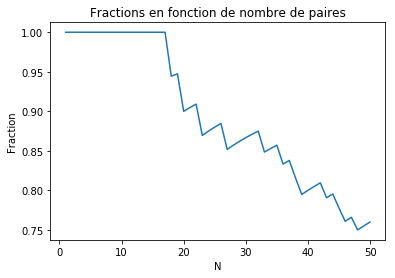

In [62]:
plt.title("Fractions en fonction de nombre de paires")
plt.plot(nb,fractions)
plt.xlabel("N")
plt.ylabel("Fraction")
plt.show()

In [55]:
res

[(34, 45, 0.7743709436385947), (36, 37, 0.710204102627232)]